In [92]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


In [93]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())
#doenload MNIST dataset and transforming it to pytorch tensors as pytorch does not understand PIL images

In [94]:
val_size=10000
train_size=len(dataset)-val_size

train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

#creating a randomly choosen validation dataset and a training dataset


(50000, 10000)

In [95]:
batch_size=128

In [96]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

#taking small batches of data and performing gradient descent on these batches
#num_workers- how many subprocesses to use for data loading 
#0 means data will be loaded in the main process 
#basically for parallel processing
#pin_memory=True the data loader will copy Tensors into CUDA pinned memory before returning them.

images.shape: torch.Size([128, 1, 28, 28])


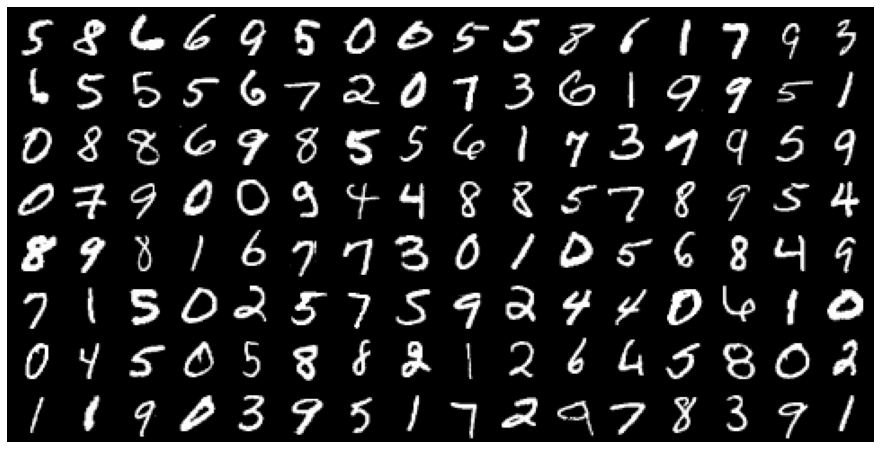

In [97]:
for images ,_ in train_loader:
    print("images.shape:",images.shape)
    plt.figure(figsize=(16,8))  #pecifying the figure size
    plt.axis("off")             #for not printing the x and y axis
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break
    
#matplotlib expects the channel dimension to be the last dimension
#eg [28,28,1]
#to plot multiple images as a single image we use make_grid
#we pass images to make_grid
#nrow specifies number of rows of images
#what permute does is it takes 0th dimension and puts it at the end and 
#1st and 2nd dimension are shifted ahead



Instead of using nn.Linear object to transform a batch of inputs into a batch of outputs  we will use two nn.Linear objects.Each of these is called a layer in the network.

The first layer also known as the hidden layer wil transform the input matrix of shape batch_size * hidden_size,where hidden_size is preconfigured eg.-32 or 64

The intermediate outputs ae then passed into a non-linear activation function,which operates on individual elements of the output matrix.

The result of the activation function which is also of size batch_size * hidden_size,is passed into the second layer which transforms it into a matrix of size batch_size * 10 , identical to the output of the logistic regression model.


The activation function we will use here is called a Rectified Linear Unit or ReLU and it has really simple formula relu(x) = max(0,x) that is if a element is negative we replace it by 0 otherwise leave it unchanged



In [98]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [119]:
class MnistModel(nn.Module):
    #Feedforward new=ural network with 1 hidden layer
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        #hidden layer
        self.linear1=nn.Linear(in_size,hidden_size)
        #output layer
        self.linear2=nn.Linear(hidden_size,out_size)
        
    def forward(self,xb):
        #Flatten the image
        xb=xb.view(xb.size(0),-1)  #reshapes it to (batchsize,784)
        #GEt intermediate outputs using hidden layer
        out=self.linear1(xb)
        #Apply activation function
        out=F.relu(out)
        #replace negative numbers by 0
        out=self.linear2(out)
        return out
        
    def training_step(self,batch):
        images,labels=batch
        out=self(images)      #generate predictions
        loss=F.cross_entropy(out,labels)  #calculate loss
        return loss
    
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)                  #generate predictions
        loss=F.cross_entropy(out,labels)  #calculate loss
        acc=accuracy(out,labels)           #calculate accuracy
        return {"val_loss":loss.detach(),"val_acc":acc}  
    #while doing gradient descent gpu keeps track of all variables used so better detach validation loss as it will also be stored in the gpu.
    
    def validation_epoch_end(self,outputs):
        batch_losses=[x["val_loss"] for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()   #combine losses
        batch_accs=[x["val_acc"] for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()     #combine accuracies
        return {"val_loss":epoch_loss.item(),"val_acc":epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}],val_loss: {:.4f},val_acc: {:.4f}".format(epoch,result["val_loss"],result["val_acc"]))
        
        
        
        
        
        
        

In [120]:
#example
a=torch.tensor([[[[2,2],[3,3]]],[[[2,2],[3,3]]],[[[2,2],[3,3]]]])
print(a.shape)
c=a.view(a.size(0),-1)
b=a.reshape(-1,4)
print(b)
print(c)

torch.Size([3, 1, 2, 2])
tensor([[2, 2, 3, 3],
        [2, 2, 3, 3],
        [2, 2, 3, 3]])
tensor([[2, 2, 3, 3],
        [2, 2, 3, 3],
        [2, 2, 3, 3]])


In [121]:
input_size=784
hidden_size=32
num_classes=10


In [122]:
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)

In [123]:
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [124]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [134]:
#only using the model 
for images,labels in train_loader:
    outputs=model(images)
    loss=F.cross_entropy(outputs,labels)
    print('Loss',loss.item())
    break
print("Outputs shape:",outputs.shape)
print("sample outputs : \n",outputs[:2].data)

Loss 0.20016147196292877
Outputs shape: torch.Size([128, 10])
sample outputs : 
 tensor([[-1.6748,  1.3361,  0.7739, 11.7297, -4.6452,  3.0863, -4.0915, -4.9229,
         -2.1069, -1.6928],
        [-0.6089, -5.3053, -4.0411, -2.6720, -4.4920, 11.0986,  3.8469, -4.0511,
          3.8709, -0.6246]], device='cuda:0')


In [135]:
#gpu graphic processing unit

In [136]:
torch.cuda.is_available()
#to check if a gpu is available and the required NVIDIA CUDA drivers are installed

True

In [137]:
def get_default_device():
    #pick GPU if available else CPU
    #cuda is the language that NVIDIA provides to program the gpu
    if torch.cuda.is_available():
        return torch.device("cuda")  #pytorch identifies cpu and gpu as separate devices 
    else:
        return torch.device("cpu")

In [138]:
device=get_default_device()
device

device(type='cuda')

In [139]:
#this function takes a data(tensor or a model) and moves it to the device
def to_device(data,device):
    if isinstance(data,(list,tuple)):   #to check if tuple or list of tensors and move them to device
        return [to_device(x,device) for x in data]   
    return data.to(device,non_blocking=True) #in case of a single tensor

#data to be copied.to(device in which it has to be copied)  
#blocking =True  to do all this in the background so next lines of code will get executed

In [140]:
for images,labels in train_loader:
    print(images.shape)
    images=to_device(images,device) #to move images to device
    print(images.device)
    print(images)
    break
    

torch.Size([128, 1, 28, 28])
cuda:0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [141]:
class DeviceDataLoader():
    #wrap a dataloader to move data to a device as the batches are accessed
    #moves data to device in batches
    #__iter__ method to retrieve batches of data
    #__len__ method to get the number of batches
    
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
        
    def __iter__(self):
        #yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b,self.device)  #yield method  is used to give batches of data and store them in device
    
    def __len__(self):
        #Number of batches
        return len(self.dl)
        
        
        

In [142]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

#reason why we are moving data in batches  because not all of your data may fit in the gpu

In [143]:
for xb,yb in val_loader:
    print("xb.device:",xb.device)
    print("yb:",yb)

xb.device: cuda:0
yb: tensor([3, 1, 6, 9, 8, 7, 2, 5, 5, 3, 2, 0, 2, 7, 3, 6, 2, 5, 1, 8, 3, 1, 0, 3,
        4, 8, 4, 3, 7, 9, 7, 2, 8, 0, 0, 1, 7, 1, 3, 6, 6, 5, 2, 3, 4, 5, 4, 8,
        4, 0, 1, 1, 1, 1, 2, 9, 0, 0, 0, 7, 6, 0, 5, 2, 9, 3, 6, 2, 8, 2, 3, 0,
        5, 3, 1, 8, 3, 6, 7, 7, 3, 4, 6, 1, 0, 9, 8, 0, 0, 6, 7, 0, 5, 0, 9, 9,
        1, 8, 0, 7, 1, 5, 4, 2, 6, 3, 8, 1, 7, 1, 9, 3, 0, 8, 8, 8, 6, 9, 5, 9,
        8, 7, 0, 9, 3, 7, 6, 5, 8, 3, 9, 6, 7, 2, 0, 5, 5, 9, 2, 6, 9, 3, 4, 1,
        2, 1, 5, 1, 3, 6, 4, 8, 4, 4, 3, 0, 8, 4, 1, 5, 6, 5, 2, 9, 2, 0, 4, 4,
        2, 4, 3, 6, 4, 5, 8, 7, 7, 9, 4, 1, 1, 2, 1, 0, 4, 9, 8, 8, 3, 1, 4, 0,
        0, 7, 1, 8, 0, 8, 1, 6, 0, 9, 3, 5, 9, 2, 8, 9, 8, 3, 1, 0, 1, 7, 8, 0,
        6, 6, 4, 1, 8, 4, 5, 7, 4, 2, 6, 3, 9, 8, 7, 8, 9, 2, 7, 0, 7, 0, 5, 9,
        6, 1, 1, 4, 5, 6, 2, 3, 2, 6, 3, 6, 0, 0, 5, 0], device='cuda:0')
xb.device: cuda:0
yb: tensor([5, 5, 3, 7, 3, 2, 1, 1, 2, 2, 4, 5, 4, 6, 8, 2, 5, 0, 5, 2, 7, 4, 0, 8,
  

In [144]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history=[]
    optimizer=opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        #training phase
        for batch in train_loader:
            loss=model.training_step(batch)
            loss.backward()  
            #put gradients into second layer and as inputs of second layer came from output of first layer it will calculate the derivative of first layer
            optimizer.step()  #this performs the gradient desecent
            optimizer.zero_grad()
        #validation phase
        result=evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [145]:
#Model(on gpu)
model=MnistModel(input_size,hidden_size=hidden_size,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [146]:
history=[evaluate(model,val_loader)]
history

[{'val_loss': 2.305074453353882, 'val_acc': 0.10478515923023224}]

In [147]:
history+=fit(5,0.5,model,train_loader,val_loader)  #higher learning rate is used

Epoch [0],val_loss: 0.2244,val_acc: 0.9329
Epoch [1],val_loss: 0.1684,val_acc: 0.9477
Epoch [2],val_loss: 0.1634,val_acc: 0.9508
Epoch [3],val_loss: 0.1365,val_acc: 0.9587
Epoch [4],val_loss: 0.1404,val_acc: 0.9578


In [148]:
history

[{'val_loss': 2.305074453353882, 'val_acc': 0.10478515923023224},
 {'val_loss': 0.2244291603565216, 'val_acc': 0.932910144329071},
 {'val_loss': 0.16837023198604584, 'val_acc': 0.9476562738418579},
 {'val_loss': 0.16341929137706757, 'val_acc': 0.9507812261581421},
 {'val_loss': 0.13651929795742035, 'val_acc': 0.958691418170929},
 {'val_loss': 0.14041458070278168, 'val_acc': 0.957812488079071}]

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline

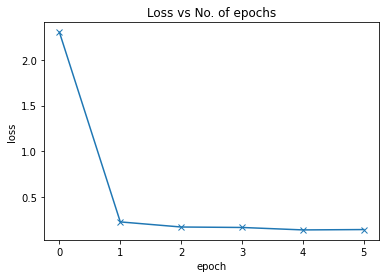

In [150]:
losses=[x["val_loss"] for x in history]
plt.plot(losses,"-x")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs No. of epochs");

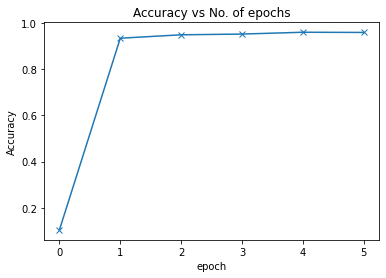

In [151]:
losses=[x["val_acc"] for x in history]
plt.plot(losses,"-x")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs No. of epochs");